In [2]:
import numpy as np
import pandas as pd

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data Preprocessing

## Dataset

In [4]:
# load 'Online Job Postings' Kaggle dataset
df_job_postings_original = pd.read_csv('data/online-job-postings-dataset.csv')

In [5]:
# extract useful columns for the career profile
df_job_postings = df_job_postings_original[[
    'jobpost', # the original job post is included just in case other columns do not contain enough information
    'Title', 'JobDescription', 'JobRequirment',
    'RequiredQual',
    'ApplicationP'
]]

# drop any row that does not have a proper 'Title' or 'JobDescription'
df_job_postings = df_job_postings[df_job_postings['Title'].notna()]
df_job_postings = df_job_postings[df_job_postings['JobDescription'].notna()].reset_index(drop=True)

In [6]:
df_job_postings

,jobpost,Title,JobDescription,JobRequirment,RequiredQual,ApplicationP
0,AMERIA Investment Consulting Company\r\nJOB TI...,Chief Financial Officer,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\r\nindivi...","To apply for this position, please submit a\r\..."
1,Caucasus Environmental NGO Network (CENN)\r\nJ...,Country Coordinator,Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",Please send resume or CV toursula.kazarian@......
2,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,BCC Specialist,The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci...",Please send cover letter and resume to Amy\r\n...
3,"Boutique ""Appollo""\r\nJOB TITLE: Saleswoman\r...",Saleswoman,Saleswoman will sell menswear and accessories.,NaN,"- Candidates should be female, 20-30 years old...","For further information, please contact Irina\..."
4,OSI Assistance Foundation - Armenian Branch Of...,Chief Accountant/ Finance Assistant,The Armenian Branch Office of the Open Society...,NaN,- University degree in finance/ accounting; \r...,"For submission of applications/ CVs, please\r\..."
...,...,...,...,...,...,...
15085,Macadamian AR CJSC\r\n\r\n\r\nTITLE: .NET Dev...,.NET Developer,The incumbent will develop software applicatio...,- Participate in all the steps of the software...,- 2 - 5 years of experience in software develo...,"To apply for this position, please email your ..."
15086,"""Transport PIU"" State Institution of the RA Mi...",Deputy Director,The incumbent will be responsible for supporti...,- Support the Director in organizing the activ...,"- University degree in Civil Engineering, Econ...",Interested candidates are asked to submit the\...
15087,Technolinguistics NGO\r\n\r\n\r\nTITLE: Senio...,Senior Creative UX/ UI Designer,A tech startup of Technolinguistics based in N...,- Work closely with product and business teams...,- At least 5 years of experience in Interface/...,"To apply for this position, please send your\r..."
15088,San Lazzaro LLC\r\n\r\n\r\nTITLE: Head of O...,Head of Online Sales Department,San Lazzaro LLC is looking for a well-experien...,- Handle the project activites of the online s...,- At least 1 year of experience in online sale...,Interested candidates can send their CVs to:\r...


## Dataset Label Aquisition
Many of the job labels are very similar but not entirely the same, so we have to group these similar job titles together to form a more general job category.

In [37]:
# helper function
# return: LIST of tokenized words
def preprocess(text, with_stopwords=False, lemmatize=True, stemming=False):
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    if with_stopwords==False:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if not word in stop_words]
    if lemmatize==True:
        lemmatizer=WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    if stemming==True:
        stemmer=PorterStemmer()
        words = [stemmer.stem(word) for word in words]

    return words

In [7]:
# preprocess and tokenize all the job titles
job_titles = df_job_postings['Title']
job_titles_tokenized = job_titles.apply(preprocess)

In [8]:
import gensim.downloader as api

# load a pretrained word2vec model
model_w2v = api.load('word2vec-google-news-300')

In [9]:
# create document vectors for word embedding via average
def vectorize_document(documents, model):
    '''
    Generate vectors of a list of documents using a word embedding model
    '''

    features = []

    for tokens in documents:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError: continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    
    return features

In [10]:
# vectorize each job title via average
vectorized_job_titles = vectorize_document(job_titles_tokenized, model=model_w2v)

In [119]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    s_score = silhouette_score(X, km.labels_)
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_, s_score

In [129]:
# find the best number of clusters by silhouette score
scores = []
for i in range(2, 100):
    _, _, s_score = mbkmeans_clusters(
        X=vectorized_job_titles,
        k=i,
        mb=500,
        print_silhouette_values=False
    )
    scores.append(s_score)

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2
Silhouette coefficient: 0.11
Inertia:47355.33056837851


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3
Silhouette coefficient: 0.08
Inertia:45219.41286506242


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4
Silhouette coefficient: 0.10
Inertia:46159.392230315374


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 5
Silhouette coefficient: 0.10
Inertia:41078.6230571767


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 6
Silhouette coefficient: 0.08
Inertia:41284.19105595874


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 7
Silhouette coefficient: 0.10
Inertia:39491.229585416455
For n_clusters = 8


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


Silhouette coefficient: 0.09
Inertia:39313.72530811372


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 9
Silhouette coefficient: 0.10
Inertia:37386.23928683061


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 10
Silhouette coefficient: 0.12
Inertia:36508.161114071234


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 11
Silhouette coefficient: 0.11
Inertia:36246.245810667715
For n_clusters = 12


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


Silhouette coefficient: 0.09
Inertia:35462.37160719347


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 13
Silhouette coefficient: 0.07
Inertia:35818.891595784815
For n_clusters = 14


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


Silhouette coefficient: 0.10
Inertia:35333.942953705504


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 15
Silhouette coefficient: 0.10
Inertia:33753.229704006655


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 16
Silhouette coefficient: 0.12
Inertia:33199.08018566824


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 17
Silhouette coefficient: 0.11
Inertia:32839.19063098314
For n_clusters = 18


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


Silhouette coefficient: 0.10
Inertia:33416.155371644825


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 19
Silhouette coefficient: 0.12
Inertia:31991.93542250681


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 20
Silhouette coefficient: 0.14
Inertia:30638.531176557957


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 21
Silhouette coefficient: 0.12
Inertia:31134.537576138235


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 22
Silhouette coefficient: 0.11
Inertia:31229.06161637942


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 23
Silhouette coefficient: 0.13
Inertia:30302.53453673642


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 24
Silhouette coefficient: 0.13
Inertia:30126.452438622906


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 25
Silhouette coefficient: 0.14
Inertia:29256.136459844372
For n_clusters = 26


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


Silhouette coefficient: 0.13
Inertia:29756.350084746144


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 27
Silhouette coefficient: 0.14
Inertia:29011.708481526977


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 28
Silhouette coefficient: 0.15
Inertia:28291.140014529083


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 29
Silhouette coefficient: 0.15
Inertia:28420.956228570623


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 30
Silhouette coefficient: 0.15
Inertia:28170.58724717598


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 31
Silhouette coefficient: 0.14
Inertia:28287.958185862124


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 32
Silhouette coefficient: 0.15
Inertia:27856.992256024045


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 33
Silhouette coefficient: 0.14
Inertia:27783.831885627522


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 34
Silhouette coefficient: 0.15
Inertia:27023.95202486168


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 35
Silhouette coefficient: 0.17
Inertia:26509.271990037414


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 36
Silhouette coefficient: 0.15
Inertia:26759.416664326367
For n_clusters = 37


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


Silhouette coefficient: 0.15
Inertia:26789.472675943696


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 38
Silhouette coefficient: 0.15
Inertia:26419.898203914236


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 39
Silhouette coefficient: 0.15
Inertia:26543.89417707379


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 40
Silhouette coefficient: 0.16
Inertia:26079.827414884712


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 41
Silhouette coefficient: 0.17
Inertia:25746.025032734622


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 42
Silhouette coefficient: 0.18
Inertia:25347.63907915088


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 43
Silhouette coefficient: 0.17
Inertia:25418.492329658337


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 44
Silhouette coefficient: 0.16
Inertia:25848.770904243825


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 45
Silhouette coefficient: 0.17
Inertia:25274.01329781402


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 46
Silhouette coefficient: 0.18
Inertia:24636.87472931819


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 47
Silhouette coefficient: 0.19
Inertia:24605.1013433928


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 48
Silhouette coefficient: 0.17
Inertia:24655.495890012855


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 49
Silhouette coefficient: 0.17
Inertia:24707.52231961341


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 50
Silhouette coefficient: 0.17
Inertia:24645.937130363433


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 51
Silhouette coefficient: 0.16
Inertia:23865.29372852291


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 52
Silhouette coefficient: 0.18
Inertia:23886.58611611557


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 53
Silhouette coefficient: 0.19
Inertia:23541.8892961579


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 54
Silhouette coefficient: 0.18
Inertia:24172.619506940453


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 55
Silhouette coefficient: 0.18
Inertia:23679.444845102607


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 56
Silhouette coefficient: 0.18
Inertia:23354.480646004286


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 57
Silhouette coefficient: 0.20
Inertia:23201.879245745622


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 58
Silhouette coefficient: 0.17
Inertia:23285.26037389945


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 59
Silhouette coefficient: 0.18
Inertia:23568.89049329067


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 60
Silhouette coefficient: 0.19
Inertia:22892.823820121535


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 61
Silhouette coefficient: 0.20
Inertia:22554.734493623597


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 62
Silhouette coefficient: 0.19
Inertia:22843.230408362586


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 63
Silhouette coefficient: 0.19
Inertia:22635.202746541472


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 64
Silhouette coefficient: 0.19
Inertia:22848.272167219806


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 65
Silhouette coefficient: 0.18
Inertia:22664.487221912666


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 66
Silhouette coefficient: 0.20
Inertia:22439.076336288697


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 67
Silhouette coefficient: 0.21
Inertia:21902.04239734648


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 68
Silhouette coefficient: 0.21
Inertia:22046.762544211313


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 69
Silhouette coefficient: 0.19
Inertia:22395.767730828


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 70
Silhouette coefficient: 0.20
Inertia:22283.548219803004


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 71
Silhouette coefficient: 0.21
Inertia:21809.729937901062


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 72
Silhouette coefficient: 0.21
Inertia:21713.110821584603


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 73
Silhouette coefficient: 0.22
Inertia:21311.958071734916


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 74
Silhouette coefficient: 0.21
Inertia:21684.243753467887


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 75
Silhouette coefficient: 0.21
Inertia:21272.299366331117


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 76
Silhouette coefficient: 0.21
Inertia:20986.9219537582


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 77
Silhouette coefficient: 0.21
Inertia:21300.653981057687


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 78
Silhouette coefficient: 0.20
Inertia:20920.122965143724


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 79
Silhouette coefficient: 0.21
Inertia:21306.384942770943


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 80
Silhouette coefficient: 0.21
Inertia:21034.41553901881


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 81
Silhouette coefficient: 0.21
Inertia:21450.66755243313


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 82
Silhouette coefficient: 0.21
Inertia:20903.86274438094


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 83
Silhouette coefficient: 0.22
Inertia:20674.145789922248


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 84
Silhouette coefficient: 0.22
Inertia:20887.414145514085


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 85
Silhouette coefficient: 0.23
Inertia:20611.39070596435


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 86
Silhouette coefficient: 0.22
Inertia:20914.07984510131


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 87
Silhouette coefficient: 0.22
Inertia:20784.084676394552


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 88
Silhouette coefficient: 0.22
Inertia:20555.171828782066


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 89
Silhouette coefficient: 0.23
Inertia:20640.734646838624


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 90
Silhouette coefficient: 0.22
Inertia:20507.7479717459


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 91
Silhouette coefficient: 0.21
Inertia:20541.38549774305


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 92
Silhouette coefficient: 0.21
Inertia:19914.156978086994


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 93
Silhouette coefficient: 0.23
Inertia:20101.86426325515


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 94
Silhouette coefficient: 0.23
Inertia:20157.96471869652


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 95
Silhouette coefficient: 0.23
Inertia:19876.958017255063


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 96
Silhouette coefficient: 0.24
Inertia:19984.40479696871


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 97
Silhouette coefficient: 0.22
Inertia:19986.846225201927


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 98
Silhouette coefficient: 0.23
Inertia:19870.229262906254


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 99
Silhouette coefficient: 0.23
Inertia:19553.343210712937


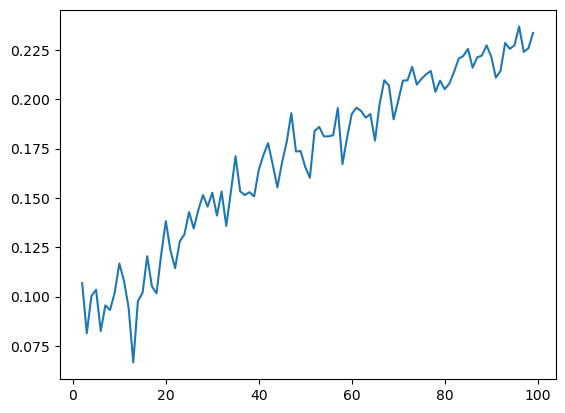

In [132]:
import matplotlib.pyplot as plt
plt.plot(list(range(2, 100)), scores)
plt.show()

In [133]:
# find the best number of clusters by silhouette score
scores = []
for i in range(200, 1000, 50):
    _, _, s_score = mbkmeans_clusters(
        X=vectorized_job_titles,
        k=i,
        mb=500,
        print_silhouette_values=False
    )
    scores.append(s_score)

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 200
Silhouette coefficient: 0.28
Inertia:15825.359843852397


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 250
Silhouette coefficient: 0.32
Inertia:14617.628627013433


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 300
Silhouette coefficient: 0.33
Inertia:13824.50251127476


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 350
Silhouette coefficient: 0.35
Inertia:13071.68640267748


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 400
Silhouette coefficient: 0.38
Inertia:12453.440300247179


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 450
Silhouette coefficient: 0.39
Inertia:11893.413274632052


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 500
Silhouette coefficient: 0.39
Inertia:11304.147320019547


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 550
Silhouette coefficient: 0.41
Inertia:10809.324244532638


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 600
Silhouette coefficient: 0.42
Inertia:10282.081075416378


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 650
Silhouette coefficient: 0.43
Inertia:10261.3728999326


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 700
Silhouette coefficient: 0.45
Inertia:9642.38753686911


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 750
Silhouette coefficient: 0.45
Inertia:9419.585956817464


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 800
Silhouette coefficient: 0.45
Inertia:9448.488293959916


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 850
Silhouette coefficient: 0.47
Inertia:8891.61019425498


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 900
Silhouette coefficient: 0.47
Inertia:8745.287973470695


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 950
Silhouette coefficient: 0.49
Inertia:8389.989457042118


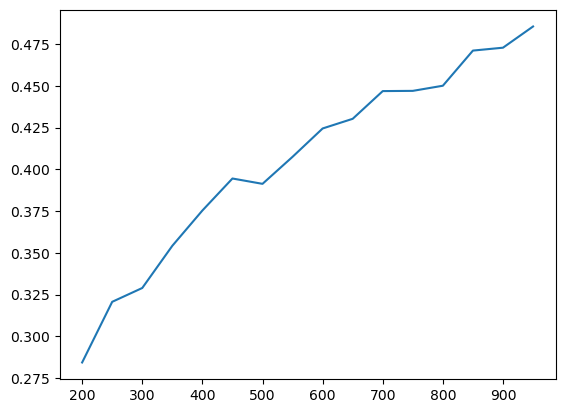

In [134]:
import matplotlib.pyplot as plt
plt.plot(list(range(200, 1000, 50)), scores)
plt.show()

In [135]:
# find the best number of clusters by silhouette score
scores = []
for i in range(1000, 5000, 100):
    _, _, s_score = mbkmeans_clusters(
        X=vectorized_job_titles,
        k=i,
        mb=500,
        print_silhouette_values=False
    )
    scores.append(s_score)

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1000
Silhouette coefficient: 0.48
Inertia:8343.486808075375


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1100
Silhouette coefficient: 0.50
Inertia:7777.411516201758


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1200
Silhouette coefficient: 0.51
Inertia:7761.139395784848


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1300
Silhouette coefficient: 0.52
Inertia:7373.042643033305


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1400
Silhouette coefficient: 0.53
Inertia:6887.373218033455


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1500
Silhouette coefficient: 0.54
Inertia:6830.686332492045


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1600
Silhouette coefficient: 0.55
Inertia:6390.16845304599


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1700
Silhouette coefficient: 0.55
Inertia:6204.529100369795


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1800
Silhouette coefficient: 0.56
Inertia:5924.020241958763


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 1900
Silhouette coefficient: 0.54
Inertia:7176.675247781882


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2000
Silhouette coefficient: 0.57
Inertia:5662.494243199713


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2100
Silhouette coefficient: 0.58
Inertia:5163.984166894702


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2200
Silhouette coefficient: 0.56
Inertia:6697.64243208389


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2300
Silhouette coefficient: 0.56
Inertia:6559.62461370682


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2400
Silhouette coefficient: 0.57
Inertia:6174.540756537664


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2500
Silhouette coefficient: 0.57
Inertia:6413.947063407154


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2600
Silhouette coefficient: 0.58
Inertia:6034.977155981688


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2700
Silhouette coefficient: 0.62
Inertia:4029.9464895121487


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2800
Silhouette coefficient: 0.60
Inertia:5404.028642280558


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 2900
Silhouette coefficient: 0.59
Inertia:5649.454779404123


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3000
Silhouette coefficient: 0.62
Inertia:4632.43962957574


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3100
Silhouette coefficient: 0.62
Inertia:4414.659408898083


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3200
Silhouette coefficient: 0.64
Inertia:3459.049868439754


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3300
Silhouette coefficient: 0.61
Inertia:4963.3186509241505


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3400
Silhouette coefficient: 0.61
Inertia:4765.006750420458


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3500
Silhouette coefficient: 0.64
Inertia:3778.5435306793734


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3600
Silhouette coefficient: 0.63
Inertia:4087.1862214795615


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3700
Silhouette coefficient: 0.63
Inertia:4227.417484854356


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3800
Silhouette coefficient: 0.64
Inertia:3879.8698453737034


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 3900
Silhouette coefficient: 0.65
Inertia:3409.080062117052


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4000
Silhouette coefficient: 0.65
Inertia:3619.717380637986


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4100
Silhouette coefficient: 0.64
Inertia:3611.674678347521


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4200
Silhouette coefficient: 0.64
Inertia:3826.136585115016


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4300
Silhouette coefficient: 0.66
Inertia:3493.9657346415693


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4400
Silhouette coefficient: 0.67
Inertia:2747.3641925810257


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4500
Silhouette coefficient: 0.67
Inertia:2774.458000238058


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4600
Silhouette coefficient: 0.65
Inertia:3496.3123415478744


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4700
Silhouette coefficient: 0.67
Inertia:2763.1063398242272


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4800
Silhouette coefficient: 0.68
Inertia:2302.41215587872


c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  "MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 4900
Silhouette coefficient: 0.69
Inertia:2294.6910943352823


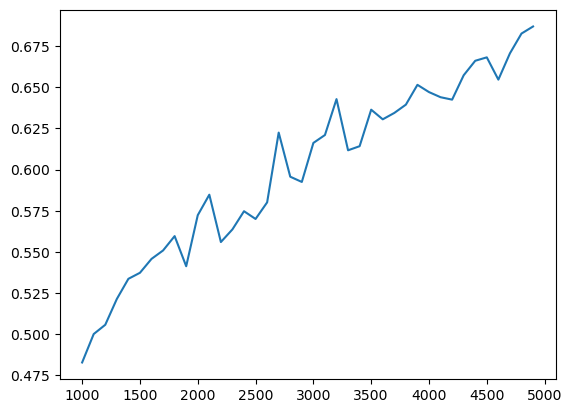

In [136]:
import matplotlib.pyplot as plt
plt.plot(list(range(1000, 5000, 100)), scores)
plt.show()

In [13]:
# get the clusters
df_clusters = pd.DataFrame({
    "text": job_titles,
    "tokens": [" ".join(text) for text in job_titles_tokenized],
    "cluster": cluster_labels
})

In [14]:
df_clusters

,text,tokens,cluster
0,Chief Financial Officer,chief financial officer,34
1,Country Coordinator,country coordinator,10
2,BCC Specialist,bcc specialist,38
3,Saleswoman,saleswoman,11
4,Chief Accountant/ Finance Assistant,chief finance assistant,32
...,...,...,...
15085,.NET Developer,developer,8
15086,Deputy Director,deputy director,17
15087,Senior Creative UX/ UI Designer,senior creative ui designer,18
15088,Head of Online Sales Department,head online sale department,30


In [15]:
print("Most representative terms per cluster (based on centroids):")
for i in range(40):
    tokens_per_cluster = ""
    most_representative = model_w2v.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: merchandiser merchandising visual_merchandiser merchandisers merchandizing 
Cluster 1: engineer engineering mechanical_engineer electrical_engineer Mike_Di_Filippo 
Cluster 2: sale manager buyer sold sell 
Cluster 3: manager vice_president manger director supervisor 
Cluster 4: finance treasurer executive vice_president Ellen_Roseman_writes 
Cluster 5: developer developers Active_Endpoints_www.activevos.com Panda_Software_www.pandasoftware.com Developer 
Cluster 6: administrative assistant adminstrative Sherri_Sera representative_Laurie_Hamit 
Cluster 7: journalist writer researcher scientist editor 
Cluster 8: developer developers Developer Developers Jack_Antaramian 
Cluster 9: translator interpreter interpretor FOREIGN_MINISTER_Via PRESIDENT_ABBAS_Via 
Cluster 10: administrator coordinator director secretary adminstrator 
Cluster 11: receptionist waitress salesperson cashier saleswoman 
Cluster 12: java developer

In [26]:
for n in range(40):
    test_cluster = n
    most_representative_docs = np.argsort(
        np.linalg.norm(vectorized_job_titles - clustering.cluster_centers_[test_cluster], axis=1)
    )
    for d in most_representative_docs[:10]:
        print(job_titles[d])
    print('----------------------------------------')

Merchandiser
Reseller/ Merchandiser
Merchandiser, Vanadzor
Merchandiser, Yerevan
Merchandiser
Merchandiser
Merchandiser
Merchandiser
Merchandiser
Merchandiser
----------------------------------------
Senior Software QA Engineer
Senior Software QA Engineer
Senior Software Engineer (EDA)
Senior Software Engineer
Senior Software Engineer
Senior Software Engineer  Java/DBMS
Senior Software Engineer
Senior Software Engineer
Senior Software Engineer
Senior Software Engineer
----------------------------------------
Sales Manager
Sales Manager
Sales Manager
Sales Manager
Sales Manager
Account/ Sales Manager
Sales Manager
Sales Manager
Sales Manager
Sales Manager
----------------------------------------
BTL Manager
Office Manager of the Country Director
Business Center Manager
Business Center Manager
Manager of Commercial Department
Manager of Commercial Department
Manager of Commercial Department
Manager of Commercial Department
Business Manager
Business Manager
-------------------------------

In [17]:
# add the cluster category to each job posting
df_job_postings['cluster'] = df_clusters['cluster']

In [19]:
# save the labeled dataset to local
df_job_postings.to_csv('data/job_postings_labeled.csv')

## Career Classification Training based on Job Description

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
df_job_postings = pd.read_csv('data/job_postings_labeled.csv', index_col=0)

In [4]:
df_job_postings.head()

,jobpost,Title,JobDescription,JobRequirment,RequiredQual,ApplicationP,cluster
0,AMERIA Investment Consulting Company\r\nJOB TI...,Chief Financial Officer,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\r\nindivi...","To apply for this position, please submit a\r\...",34
1,Caucasus Environmental NGO Network (CENN)\r\nJ...,Country Coordinator,Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",Please send resume or CV toursula.kazarian@......,10
2,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,BCC Specialist,The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci...",Please send cover letter and resume to Amy\r\n...,38
3,"Boutique ""Appollo""\r\nJOB TITLE: Saleswoman\r...",Saleswoman,Saleswoman will sell menswear and accessories.,NaN,"- Candidates should be female, 20-30 years old...","For further information, please contact Irina\...",11
4,OSI Assistance Foundation - Armenian Branch Of...,Chief Accountant/ Finance Assistant,The Armenian Branch Office of the Open Society...,NaN,- University degree in finance/ accounting; \r...,"For submission of applications/ CVs, please\r\...",32


In [5]:
df_job_postings.groupby(['cluster'], sort=True).size()

cluster
0       31
1      776
2      542
3      908
4      211
5      356
6      301
7      231
8      119
9      172
10     500
11     166
12     269
13     289
14      86
15     258
16    1772
17     270
18     294
19     528
20     485
21     163
22      78
23     230
24     107
25     521
26      50
27     415
28     146
29     145
30     939
31     312
32     430
33     241
34     341
35    1363
36     135
37     107
38     596
39     207
dtype: int64

In [6]:
# create training and testing datasets
X = df_job_postings['JobDescription']
y = df_job_postings['cluster']

### Model 1: TF-IDF + Classifier

#### Data Preparation

In [7]:
# split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=7600)

In [8]:
X_train.head()

1106    We are seeking a Brand Manager to work for a t...
3113    Deep Ray Ltd is seeking candidates for the pos...
6990    "Tonus-Les" Ltd. is looking for enthusiastic,\...
8086    The incumbent will be responsible for vehicle ...
5735    The Director will head Investment Banking Depa...
Name: JobDescription, dtype: object

In [9]:
y_train.head()

1106    27
3113    30
6990    13
8086    30
5735     4
Name: cluster, dtype: int64

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
def tfidf_preprocess(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    
    # stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

    # stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    text = ' '.join(words)

    return text

**Train TF-IDF**

In [12]:
# define tfidf vectorizer
tfidf = TfidfVectorizer(
    preprocessor=tfidf_preprocess,
    ngram_range = (1, 2),
)

# fit the tfidf to the entire X
tfidf.fit(X)

KeyboardInterrupt: 

**Load TF-IDF from local**

In [13]:
# load tfidf vectorizer from saved path
import pickle
tfidf = pickle.load(open('models/career_tfidf_vectorizer.pickle', 'rb'))

In [14]:
# transform the train and test datasets for X
X_train_tfidf_transformed = tfidf.transform(X_train)
X_test_tfidf_transformed = tfidf.transform(X_test)

In [15]:
# get shape of the tfidf transformed X_train
X_train_tfidf_transformed.shape

(10563, 104384)

In [121]:
# save the tfidf vectorizer and transformed matrices
import pickle

pickle.dump(tfidf, open('models/career_tfidf_vectorizer.pickle', 'wb'))
pickle.dump(X_train_tfidf_transformed, open('models/career_X_train_tfidf_transformed.pickle', 'wb'))
pickle.dump(X_test_tfidf_transformed, open('models/career_X_test_tfidf_transformed.pickle', 'wb'))

#### Naive Bayes (baseline)

In [76]:
from sklearn.naive_bayes import MultinomialNB

In [77]:
clf_tfidf_mnb = MultinomialNB()

In [78]:
clf_tfidf_mnb.fit(X_train_tfidf_transformed, y_train)

MultinomialNB()

In [79]:
accuracy_score(y_test, clf_tfidf_mnb.predict(X_test_tfidf_transformed))

0.3333333333333333

In [85]:
print(classification_report(y_test, clf_tfidf_mnb.predict(X_test_tfidf_transformed)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.54      0.63      0.58       232
           2       0.84      0.45      0.58       157
           3       0.75      0.33      0.45       273
           4       0.00      0.00      0.00        64
           5       0.92      0.20      0.33       111
           6       0.88      0.22      0.35        96
           7       1.00      0.06      0.11        67
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00        56
          10       0.93      0.18      0.30       141
          11       0.00      0.00      0.00        54
          12       0.83      0.72      0.77        79
          13       0.94      0.57      0.71        81
          14       0.00      0.00      0.00        29
          15       0.67      0.05      0.09        79
          16       0.18      0.98      0.31       544
          17       0.00    

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Linear SVM

In [104]:
from sklearn.linear_model import SGDClassifier

In [105]:
clf_tfidf_sgd = SGDClassifier(
    loss='hinge',
    penalty='l2',
    alpha=1e-3,
    random_state=7600,
    verbose=1
)

In [107]:
clf_tfidf_sgd.fit(X_train_tfidf_transformed, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 0.84, NNZs: 1057, Bias: -1.012067, T: 10563, Avg. loss: 0.003892
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.70, NNZs: 1371, Bias: -1.011447, T: 21126, Avg. loss: 0.003115
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.66, NNZs: 1688, Bias: -1.010589, T: 31689, Avg. loss: 0.003064
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 0.65, NNZs: 1938, Bias: -1.010838, T: 42252, Avg. loss: 0.003041
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.65, NNZs: 2147, Bias: -1.010795, T: 52815, Avg. loss: 0.003031
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.64, NNZs: 2277, Bias: -1.010073, T: 63378, Avg. loss: 0.003037
Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.01 seconds
-- Epoch 1
Norm: 4.48, NNZs: 11917, Bias: -1.048483, T: 10563, Avg. loss: 0.090813
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 4.32, NNZs: 14555, Bias: -1.042134, T: 21126, Avg. loss: 0.083768
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished


SGDClassifier(alpha=0.001, random_state=7600, verbose=1)

In [108]:
accuracy_score(y_test, clf_tfidf_sgd.predict(X_test_tfidf_transformed))

0.6567263088137839

In [109]:
print(classification_report(y_test, clf_tfidf_sgd.predict(X_test_tfidf_transformed)))

              precision    recall  f1-score   support

           0       0.50      0.23      0.32        13
           1       0.61      0.72      0.66       232
           2       0.65      0.90      0.75       157
           3       0.67      0.70      0.68       273
           4       0.67      0.41      0.50        64
           5       0.60      0.52      0.56       111
           6       0.82      0.78      0.80        96
           7       0.72      0.42      0.53        67
           8       0.67      0.33      0.44        36
           9       0.68      0.84      0.75        56
          10       0.66      0.63      0.64       141
          11       0.72      0.43      0.53        54
          12       0.67      0.94      0.78        79
          13       0.63      0.95      0.75        81
          14       0.73      0.55      0.63        29
          15       0.69      0.68      0.69        79
          16       0.60      0.71      0.65       544
          17       0.72    

#### Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression

In [99]:
clf_tfidf_lr = LogisticRegression(
    max_iter=200,
    random_state=7600,
    verbose=1,
    n_jobs=cpu_count()
)

In [100]:
clf_tfidf_lr.fit(X_train_tfidf_transformed, y_train)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:   51.4s finished


LogisticRegression(max_iter=200, n_jobs=16, random_state=7600, verbose=1)

In [102]:
accuracy_score(y_test, clf_tfidf_lr.predict(X_test_tfidf_transformed))

0.6114424563728739

In [103]:
print(classification_report(y_test, clf_tfidf_lr.predict(X_test_tfidf_transformed)))

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.70      0.70      0.70       232
           2       0.79      0.84      0.81       157
           3       0.61      0.67      0.64       273
           4       0.62      0.36      0.46        64
           5       0.68      0.50      0.57       111
           6       0.83      0.67      0.74        96
           7       1.00      0.24      0.39        67
           8       0.90      0.25      0.39        36
           9       0.77      0.43      0.55        56
          10       0.78      0.52      0.63       141
          11       1.00      0.09      0.17        54
          12       0.85      0.87      0.86        79
          13       0.90      0.79      0.84        81
          14       1.00      0.17      0.29        29
          15       0.77      0.65      0.70        79
          16       0.45      0.82      0.58       544
          17       0.78    

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### CNN

In [16]:
import torch
import scipy

from torch import nn

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# set up gpu for training
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name: ', torch.cuda.get_device_name(0))

else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
Device name:  NVIDIA GeForce RTX 3080 Ti


In [18]:
# convert X tfidf vectors to tensor
X_train_tfidf_tensor = torch.tensor(scipy.sparse.csr_matrix(X_train_tfidf_transformed).todense()).float().to(device)
X_test_tfidf_tensor = torch.tensor(scipy.sparse.csr_matrix(X_test_tfidf_transformed).todense()).float()

# convert y vectors to tensor
y_train_tensor = torch.tensor(y_train.values).to(device)
y_test_tensor = torch.tensor(y_test.values)

In [27]:
# define cnn model
clf_tfidf_cnn = nn.Sequential(
    nn.Linear(X_train_tfidf_tensor.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, df_job_postings['cluster'].nunique()),
    nn.LogSoftmax(dim=1)
)
clf_tfidf_cnn.to(device)

Sequential(
  (0): Linear(in_features=104384, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=40, bias=True)
  (3): LogSoftmax(dim=1)
)

In [29]:
# define loss
criterion = nn.NLLLoss()
logps = clf_tfidf_cnn(X_train_tfidf_tensor)
loss = criterion(logps, y_train_tensor)

loss.backward()

# define optimizer
optimizer = torch.optim.Adam(clf_tfidf_cnn.parameters(), lr=2e-3)

In [30]:
# define parameters for model training
EPOCHS = 50

In [31]:
# train the model
for epoch in range(EPOCHS):
    # zero the paramater gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = clf_tfidf_cnn.forward(X_train_tfidf_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # print statistics
    print(f'Epoch: {epoch}')

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


In [32]:
# evaluate our model
with torch.no_grad():
    clf_tfidf_cnn.eval()
    log_ps = clf_tfidf_cnn(X_test_tfidf_tensor)
    test_loss = criterion(log_ps, y_test_tensor)

    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == y_test_tensor.view(*top_class.shape)
    test_accuracy = torch.mean(equals.float())

In [33]:
test_accuracy

tensor(0.4632, device='cuda:0')

#### LSTM (fixed length) - memory error

In [19]:
import torch.nn.functional as F

In [20]:
class FixedLengthLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, df_job_postings['cluster'].nunique())
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [21]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        optimizer.zero_grad()
        outputs = model.forward(X_train_tfidf_tensor)
        loss = F.cross_entropy(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    
def validation_metrics(model, X_test, y_test):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0

    for x in X_test:
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y_test)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y_test).float().sum()
        total += y_test.shape[0]
        sum_loss += loss.item()*y_test.shape[0]
    return sum_loss/total, correct/total

In [22]:
clf_tfidf_lstm_fixed = FixedLengthLSTM(X_train_tfidf_tensor.shape[1], 16)
clf_tfidf_lstm_fixed.to(device)

FixedLengthLSTM(
  (lstm): LSTM(104384, 16, batch_first=True)
  (linear): Linear(in_features=16, out_features=40, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [300]:
train_model(clf_tfidf_lstm_fixed)

RuntimeError: CUDA out of memory. Tried to allocate 4.11 GiB (GPU 0; 12.00 GiB total capacity; 5.16 GiB already allocated; 197.57 MiB free; 8.25 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Model 2: Word2Vec (mean of word vectors) + Classifier

#### Data Preparation

In [24]:
# split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=7600)

In [25]:
X_train.head()

1106    We are seeking a Brand Manager to work for a t...
3113    Deep Ray Ltd is seeking candidates for the pos...
6990    "Tonus-Les" Ltd. is looking for enthusiastic,\...
8086    The incumbent will be responsible for vehicle ...
5735    The Director will head Investment Banking Depa...
Name: JobDescription, dtype: object

In [26]:
y_train.head()

1106    27
3113    30
6990    13
8086    30
5735     4
Name: cluster, dtype: int64

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kackie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [67]:
def w2v_preprocess(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    
    # stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

    # stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    return words

In [68]:
from gensim.models import Word2Vec
from os import cpu_count

In [69]:
# preprocess the X texts
X_tokenized = X.apply(w2v_preprocess)
X_tokenized

0        [ameria, invest, consult, compani, seek, chief...
1        [public, outreach, strengthen, grow, network, ...
2        [lead, local, enhanc, develop, health, bcc, sp...
3                  [saleswoman, sell, menswear, accessori]
4        [armenian, branch, offic, open, societi, insti...
                               ...                        
15085    [incumb, develop, softwar, applic, work, distr...
15086    [incumb, respons, support, director, organ, ac...
15087    [tech, startup, technolinguist, base, new, yor...
15088    [san, lazzaro, llc, look, individu, work, head...
15089    [kamurj, uco, cjsc, look, lawyer, legal, depar...
Name: JobDescription, Length: 15090, dtype: object

**Train Word2Vec**

In [70]:
# train our own word2vec model using the career corpus
w2v = Word2Vec(
    sentences=X_tokenized, 
    vector_size=300, 
    window=5,
    min_count=1,
    workers=cpu_count()
)

In [77]:
len(w2v.wv)

7171

In [71]:
# save the w2v model 
w2v.save('models/career_w2v.model')

**Convert train & test datasets to Word2Vec**

In [274]:
# get sentence vectors for each row of the training and testing X datasets
def get_w2v_sentence_vector(text, model):
    sentence_vector = np.nanmean(np.array([model[i] for i in w2v_preprocess(text)]), axis=0).tolist()
    if not isinstance(sentence_vector, list):
        sentence_vector = [0]*300
    return sentence_vector

X_train_w2v_transformed = []
for text in X_train:
    sentence_vector = get_w2v_sentence_vector(text, w2v.wv)
    X_train_w2v_transformed.append(sentence_vector)

X_test_w2v_transformed = []
for text in X_test:
    sentence_vector = get_w2v_sentence_vector(text, w2v.wv)
    X_test_w2v_transformed.append(sentence_vector)

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [275]:
X_train_w2v_transformed = np.array(X_train_w2v_transformed)
X_test_w2v_transformed = np.array(X_test_w2v_transformed)

In [276]:
X_train_w2v_transformed.shape

(10563, 300)

In [277]:
X_test_w2v_transformed.shape

(4527, 300)

#### Naive Bayes (baseline)

In [278]:
from sklearn.naive_bayes import MultinomialNB

In [285]:
# since MNB can only do positive values, we need to normalize the word embeddings
from sklearn.preprocessing import MinMaxScaler
X_train_w2v_transformed_scaled = MinMaxScaler().fit_transform(X_train_w2v_transformed)
X_test_w2v_transformed_scaled = MinMaxScaler().fit_transform(X_test_w2v_transformed)

In [286]:
clf_w2v_mnb = MultinomialNB()

In [287]:
clf_w2v_mnb.fit(X_train_w2v_transformed_scaled, y_train)

MultinomialNB()

In [288]:
accuracy_score(y_test, clf_w2v_mnb.predict(X_test_w2v_transformed_scaled))

0.2701568367572344

In [289]:
print(classification_report(y_test, clf_w2v_mnb.predict(X_test_w2v_transformed_scaled)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.30      0.51      0.38       232
           2       0.41      0.68      0.51       157
           3       0.26      0.29      0.28       273
           4       0.25      0.05      0.08        64
           5       0.50      0.09      0.15       111
           6       0.44      0.44      0.44        96
           7       0.00      0.00      0.00        67
           8       0.06      0.08      0.07        36
           9       0.38      0.36      0.37        56
          10       0.59      0.23      0.34       141
          11       0.05      0.07      0.06        54
          12       0.19      0.52      0.28        79
          13       0.69      0.62      0.65        81
          14       0.00      0.00      0.00        29
          15       0.29      0.42      0.34        79
          16       0.27      0.62      0.37       544
          17       0.00    

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Linear SVM

In [290]:
from sklearn.linear_model import SGDClassifier

In [291]:
clf_w2v_sgd = SGDClassifier(
    loss='hinge',
    penalty='l2',
    alpha=1e-3,
    random_state=7600,
    verbose=1
)

In [292]:
clf_w2v_sgd.fit(X_train_w2v_transformed, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 0.84, NNZs: 300, Bias: -3.994332, T: 10563, Avg. loss: 0.011362
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.90, NNZs: 300, Bias: -3.556771, T: 21126, Avg. loss: 0.005836
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 0.81, NNZs: 300, Bias: -3.344102, T: 31689, Avg. loss: 0.005314
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 0.72, NNZs: 300, Bias: -3.208036, T: 42252, Avg. loss: 0.004855
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 0.75, NNZs: 300, Bias: -3.061649, T: 52815, Avg. loss: 0.004722
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 0.69, NNZs: 300, Bias: -2.976538, T: 63378, Avg. loss: 0.004517
Total training time: 0.03 seconds.
-- Epoch 7
Norm: 0.64, NNZs: 300, Bias: -2.904785, T: 73941, Avg. loss: 0.004506
Total training time: 0.03 seconds.
Convergence after 7 epochs took 0.03 seconds
-- Epoch 1
Norm: 4.04, NNZs: 300, Bias: -2.815307, T: 10563, Avg. loss: 0.332334
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 3.24, NNZs

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.5s finished


SGDClassifier(alpha=0.001, random_state=7600, verbose=1)

In [293]:
accuracy_score(y_test, clf_w2v_sgd.predict(X_test_w2v_transformed))

0.35012149326264635

In [294]:
print(classification_report(y_test, clf_w2v_sgd.predict(X_test_w2v_transformed)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.46      0.50      0.48       232
           2       0.53      0.78      0.63       157
           3       0.62      0.30      0.40       273
           4       0.00      0.00      0.00        64
           5       0.20      0.01      0.02       111
           6       0.63      0.28      0.39        96
           7       0.40      0.03      0.06        67
           8       0.00      0.00      0.00        36
           9       0.51      0.48      0.50        56
          10       0.48      0.41      0.44       141
          11       0.00      0.00      0.00        54
          12       0.69      0.65      0.67        79
          13       0.66      0.84      0.74        81
          14       0.00      0.00      0.00        29
          15       0.89      0.20      0.33        79
          16       0.37      0.63      0.47       544
          17       0.00    

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Logistic Regression

In [295]:
from sklearn.linear_model import LogisticRegression

In [296]:
clf_w2v_lr = LogisticRegression(
    max_iter=200,
    random_state=7600,
    verbose=1,
    n_jobs=cpu_count()
)

In [297]:
clf_w2v_lr.fit(X_train_w2v_transformed, y_train)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:    9.1s finished


LogisticRegression(max_iter=200, n_jobs=16, random_state=7600, verbose=1)

In [298]:
accuracy_score(y_test, clf_w2v_lr.predict(X_test_w2v_transformed))

0.46277888226198366

In [299]:
print(classification_report(y_test, clf_w2v_lr.predict(X_test_w2v_transformed)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.46      0.58      0.51       232
           2       0.59      0.78      0.67       157
           3       0.48      0.52      0.50       273
           4       0.47      0.27      0.34        64
           5       0.38      0.36      0.37       111
           6       0.57      0.48      0.52        96
           7       0.41      0.13      0.20        67
           8       0.33      0.08      0.13        36
           9       0.60      0.46      0.53        56
          10       0.53      0.44      0.48       141
          11       0.23      0.11      0.15        54
          12       0.59      0.78      0.67        79
          13       0.82      0.84      0.83        81
          14       0.33      0.10      0.16        29
          15       0.75      0.56      0.64        79
          16       0.43      0.66      0.52       544
          17       0.50    

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 3: Doc2Vec + Classifier

#### Data Preparation

In [369]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
import logging
logging.basicConfig(level=logging.INFO)

In [383]:
X_tokenized_nonempty_indices = X_tokenized[X_tokenized.apply(lambda x: len(x)>0)].index
y_nonempty = y[y.index.isin(X_tokenized_nonempty_indices)]
print(len(y_nonempty))
y_nonempty

15079


0        34
1        10
2        38
3        11
4        32
         ..
15085     8
15086    17
15087    18
15088    30
15089    16
Name: cluster, Length: 15079, dtype: int64

In [384]:
# remove the documents that have no tokenized words from the X_tokenized list
X_tokenized_nonempty = X_tokenized[X_tokenized.apply(lambda x: len(x)>0)]
print(len(X_tokenized_nonempty))
X_tokenized_nonempty

15079


0        [ameria, invest, consult, compani, seek, chief...
1        [public, outreach, strengthen, grow, network, ...
2        [lead, local, enhanc, develop, health, bcc, sp...
3                  [saleswoman, sell, menswear, accessori]
4        [armenian, branch, offic, open, societi, insti...
                               ...                        
15085    [incumb, develop, softwar, applic, work, distr...
15086    [incumb, respons, support, director, organ, ac...
15087    [tech, startup, technolinguist, base, new, yor...
15088    [san, lazzaro, llc, look, individu, work, head...
15089    [kamurj, uco, cjsc, look, lawyer, legal, depar...
Name: JobDescription, Length: 15079, dtype: object

In [385]:
# convert the texts into tagged document format as required by doc2vec
tagged = []
for i in range(len(X_tokenized_nonempty)):
    try:
        tagged_document = TaggedDocument(
            words = X_tokenized_nonempty[i],
            tags = [y[i]]
        )
        tagged.append(tagged_document)
    except:
        continue

print(tagged[0])

TaggedDocument<['ameria', 'invest', 'consult', 'compani', 'seek', 'chief', 'financi', 'offic', 'posit', 'manag', 'compani', 'fiscal', 'administr', 'function', 'provid', 'highli', 'respons', 'technic', 'complex', 'staff', 'assist', 'execut', 'director', 'work', 'perform', 'requir', 'high', 'level', 'technic', 'profici', 'financi', 'manag', 'invest', 'manag', 'well', 'manag', 'supervisori', 'administr', 'skill'], [34]>


In [386]:
# train the doc2vec model
d2v = Doc2Vec(
    dm=0,
    vector_size=300,
    negative=5,
    hs=0,
    min_count=1,
    sample=0,
    epochs=30,
    workers=cpu_count()
)
d2v.build_vocab(tagged)
d2v.train(tagged, total_examples=d2v.corpus_count, epochs=d2v.epochs)

INFO:gensim.utils:Doc2Vec lifecycle event {'params': 'Doc2Vec<dbow,d300,n5,t16>', 'datetime': '2022-09-27T11:27:16.197366', 'gensim': '4.2.0', 'python': '3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #10000, processed 228741 words (7898842 words/s), 5953 word types, 0 tags
INFO:gensim.models.doc2vec:collected 7165 word types and 40 unique tags from a corpus of 15068 examples and 355957 words
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 7165 unique words (100.00% of original 7165, drops 0)', 'datetime': '2022-09-27T11:27:16.263931', 'gensim': '4.2.0', 'python': '3.7.13 (default, Mar 28 2022, 08:03:21

In [499]:
# save the d2v model
d2v.save('models/d2v_online_job_descriptions.model')

INFO:gensim.utils:Doc2Vec lifecycle event {'fname_or_handle': 'models/d2v_online_job_descriptions.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-09-27T12:14:34.851723', 'gensim': '4.2.0', 'python': '3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'saving'}
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved models/d2v_online_job_descriptions.model


In [500]:
# load the saved model
temp = Doc2Vec.load('models/d2v_online_job_descriptions.model')

INFO:gensim.utils:loading Doc2Vec object from models/d2v_online_job_descriptions.model
INFO:gensim.utils:loading dv recursively from models/d2v_online_job_descriptions.model.dv.* with mmap=None
INFO:gensim.utils:loading wv recursively from models/d2v_online_job_descriptions.model.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Doc2Vec lifecycle event {'fname': 'models/d2v_online_job_descriptions.model', 'datetime': '2022-09-27T12:15:02.305732', 'gensim': '4.2.0', 'python': '3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'loaded'}


In [428]:
# split nonempty dataset into train and test datasets
X_train_tokenized_nonempty, X_test_tokenized_nonempty, y_train_nonempty, y_test_nonempty = train_test_split(
    X_tokenized_nonempty, y_nonempty, test_size=0.3, shuffle=True, random_state=7600
)

In [429]:
X_train_d2v = X_train_tokenized_nonempty.apply(lambda x: d2v.infer_vector(x))
X_test_d2v = X_test_tokenized_nonempty.apply(lambda x: d2v.infer_vector(x))

In [430]:
def convert_series_to_array(series):
    temp = []
    for x in series:
        temp.append(x.tolist())

    return np.array(temp)

X_train_d2v = convert_series_to_array(X_train_d2v)
X_test_d2v = convert_series_to_array(X_test_d2v)

In [432]:
X_train_d2v.shape

(10555, 300)

#### Naive Bayes (baseline)

In [433]:
from sklearn.naive_bayes import MultinomialNB

In [438]:
# since MNB can only do positive values, we need to normalize the word embeddings
from sklearn.preprocessing import MinMaxScaler
X_train_d2v_transformed_scaled = MinMaxScaler().fit_transform(X_train_d2v)
X_test_d2v_transformed_scaled = MinMaxScaler().fit_transform(X_test_d2v)

In [439]:
clf_d2v_mnb = MultinomialNB()

In [440]:
clf_d2v_mnb.fit(X_train_d2v_transformed_scaled, y_train_nonempty)

MultinomialNB()

In [441]:
accuracy_score(y_test_nonempty, clf_d2v_mnb.predict(X_test_d2v_transformed_scaled))

0.4363395225464191

In [442]:
print(classification_report(y_test_nonempty, clf_d2v_mnb.predict(X_test_d2v_transformed_scaled)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.55      0.74      0.63       237
           2       0.83      0.57      0.68       172
           3       0.43      0.48      0.46       251
           4       1.00      0.14      0.25        57
           5       0.91      0.17      0.29       115
           6       0.80      0.39      0.53        71
           7       0.70      0.12      0.20        60
           8       0.00      0.00      0.00        39
           9       0.73      0.17      0.28        47
          10       0.84      0.32      0.46       147
          11       1.00      0.13      0.23        46
          12       0.91      0.54      0.68        76
          13       0.88      0.55      0.68        80
          14       0.86      0.26      0.40        23
          15       0.75      0.08      0.14        75
          16       0.29      0.92      0.45       529
          17       1.00    

c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kackie\anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Linear SVM

In [443]:
from sklearn.linear_model import SGDClassifier

In [444]:
clf_d2v_sgd = SGDClassifier(
    loss='hinge',
    penalty='l2',
    alpha=1e-3,
    random_state=7600,
    verbose=1
)

In [446]:
clf_d2v_sgd.fit(X_train_d2v, y_train_nonempty)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 1.59, NNZs: 300, Bias: -4.439741, T: 10555, Avg. loss: 0.014464
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.51, NNZs: 300, Bias: -3.980765, T: 21110, Avg. loss: 0.005580
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 1.49, NNZs: 300, Bias: -3.691271, T: 31665, Avg. loss: 0.005033
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 1.36, NNZs: 300, Bias: -3.558167, T: 42220, Avg. loss: 0.004710
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 1.35, NNZs: 300, Bias: -3.406475, T: 52775, Avg. loss: 0.004558
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 1.30, NNZs: 300, Bias: -3.303278, T: 63330, Avg. loss: 0.004508
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 1.30, NNZs: 300, Bias: -3.204145, T: 73885, Avg. loss: 0.004393
Total training time: 0.03 seconds.
Convergence after 7 epochs took 0.03 seconds
-- Epoch 1
Norm: 4.72, NNZs: 300, Bias: -0.387570, T: 10555, Avg. loss: 0.147571
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 4.00, NNZs

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished


SGDClassifier(alpha=0.001, random_state=7600, verbose=1)

In [448]:
accuracy_score(y_test_nonempty, clf_d2v_sgd.predict(X_test_d2v))

0.7203801945181255

In [447]:
print(classification_report(y_test_nonempty, clf_d2v_sgd.predict(X_test_d2v)))

              precision    recall  f1-score   support

           0       0.50      0.22      0.31         9
           1       0.67      0.82      0.74       237
           2       0.79      0.86      0.82       172
           3       0.72      0.69      0.70       251
           4       0.88      0.53      0.66        57
           5       0.70      0.58      0.64       115
           6       0.81      0.80      0.81        71
           7       0.72      0.78      0.75        60
           8       0.39      0.44      0.41        39
           9       0.86      0.77      0.81        47
          10       0.75      0.75      0.75       147
          11       0.81      0.83      0.82        46
          12       0.65      0.92      0.76        76
          13       0.87      0.99      0.92        80
          14       0.57      0.57      0.57        23
          15       0.73      0.84      0.78        75
          16       0.61      0.74      0.66       529
          17       0.78    

#### Logistic Regression

In [449]:
from sklearn.linear_model import LogisticRegression

In [450]:
clf_d2v_lr = LogisticRegression(
    max_iter=200,
    random_state=7600,
    verbose=1,
    n_jobs=cpu_count()
)

In [451]:
clf_d2v_lr.fit(X_train_d2v, y_train_nonempty)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 out of   1 | elapsed:   10.6s finished


LogisticRegression(max_iter=200, n_jobs=16, random_state=7600, verbose=1)

In [452]:
accuracy_score(y_test_nonempty, clf_d2v_lr.predict(X_test_d2v))

0.75552608311229

In [453]:
print(classification_report(y_test_nonempty, clf_d2v_lr.predict(X_test_d2v)))

              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.77      0.80      0.78       237
           2       0.82      0.85      0.83       172
           3       0.69      0.74      0.71       251
           4       0.76      0.65      0.70        57
           5       0.74      0.68      0.71       115
           6       0.76      0.83      0.79        71
           7       0.80      0.80      0.80        60
           8       0.78      0.54      0.64        39
           9       0.87      0.72      0.79        47
          10       0.80      0.73      0.77       147
          11       0.95      0.76      0.84        46
          12       0.77      0.92      0.84        76
          13       0.93      0.99      0.96        80
          14       0.75      0.52      0.62        23
          15       0.82      0.79      0.80        75
          16       0.69      0.70      0.69       529
          17       0.78    

In [535]:
# print confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_nonempty, clf_d2v_lr.predict(X_test_d2v))

array([[  6,   0,   0, ...,   0,   0,   0],
       [  0, 189,   0, ...,   2,   0,   0],
       [  0,   0, 146, ...,   0,   2,   0],
       ...,
       [  0,   3,   0, ...,  27,   2,   0],
       [  0,   1,   2, ...,   0, 113,   0],
       [  0,   1,   0, ...,   0,   0,  51]], dtype=int64)

In [472]:
# sample test data prediction
print(f'Original job post:\n{X[4737]}\n')
print(f'Ground truth label: {y[4737]}\n')
print(f'Predicted label: {clf_d2v_lr.predict(X_test_d2v)[0]}')

Original job post:
Cascade Bank CSJC is looking for a motivated and
proactive candidate for the position of Reporting Officer in Lending
Department.

Ground truth label: 23

Predicted label: 23


In [10]:
clf_d2v_lr.predict([d2v.infer_vector(w2v_preprocess('I am good with excel and microsoft. I also like writing.'))])
df_job_postings.loc[df_job_postings['cluster']==35]

NameError: name 'clf_d2v_lr' is not defined

In [536]:
# save model
from joblib import dump
dump(clf_d2v_lr, 'models/clf_d2v_lr_career.joblib')

['models/clf_d2v_lr_career.joblib']

#### CNN

In [473]:
import torch
import scipy

from torch import nn

In [474]:
# set up gpu for training
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name: ', torch.cuda.get_device_name(0))

else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
Device name:  NVIDIA GeForce RTX 3080 Ti


In [489]:
# convert X d2v vectors to tensor
X_train_d2v_tensor = torch.tensor(X_train_d2v).float().to(device)
X_test_d2v_tensor = torch.tensor(X_test_d2v).float().to(device)

# convert y vectors to tensor
y_train_nonempty_tensor = torch.tensor(y_train_nonempty.values).to(device)
y_test_nonempty_tensor = torch.tensor(y_test_nonempty.values).to(device)

In [490]:
# define cnn model
clf_d2v_cnn = nn.Sequential(
    nn.Linear(X_train_d2v_tensor.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_nonempty.nunique()),
    nn.LogSoftmax(dim=1)
)
clf_d2v_cnn.to(device)

Sequential(
  (0): Linear(in_features=300, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=40, bias=True)
  (3): LogSoftmax(dim=1)
)

In [491]:
# define loss
criterion = nn.NLLLoss()
logps = clf_d2v_cnn(X_train_d2v_tensor)
loss = criterion(logps, y_train_nonempty_tensor)

loss.backward()

# define optimizer
optimizer = torch.optim.Adam(clf_d2v_cnn.parameters(), lr=2e-3)

In [492]:
# define parameters for model training
EPOCHS = 50

In [493]:
# train the model
for epoch in range(EPOCHS):
    # zero the paramater gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = clf_d2v_cnn.forward(X_train_d2v_tensor)
    loss = criterion(outputs, y_train_nonempty_tensor)
    loss.backward()
    optimizer.step()

    # print statistics
    print(f'Epoch: {epoch}')

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


In [494]:
# evaluate our model
with torch.no_grad():
    clf_d2v_cnn.eval()
    log_ps = clf_d2v_cnn(X_test_d2v_tensor)
    test_loss = criterion(log_ps, y_test_nonempty_tensor)

    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == y_test_nonempty_tensor.view(*top_class.shape)
    test_accuracy = torch.mean(equals.float())

In [495]:
test_accuracy

tensor(0.4996, device='cuda:0')

## After Classification Model - Cluster to Job Title Mapping + Job Description Keywords

In [8]:
# read the saved dataset
df_job_postings = pd.read_csv('data/job_postings_labeled.csv', index_col=0)

In [9]:
# sample - find the mapping between the cluster no. and the top 5 most frequent job titles associated with that cluster
df_job_postings.loc[df_job_postings['cluster'] == 35]['Title'].value_counts().index[:5]

Index(['English Language Instructor', 'English Language Specialist',
       'C#.NET Senior Developer/ Architect', 'Team Leader',
       'Announcements Moderator'],
      dtype='object')